In [27]:
import deepquantum as dq
import numpy as np
import torch
print('version',dq.__version__)

version 3.1.1


# 基于Fock 后端构建光量子线路

## 基础

a. 初始化线路需要的参数：\
nmode: 表示mode 数 \
init_state: 表示初态设置， 初态设置有两种，fock basis 输入 [1,0,1,0], 此时basis=True, 或者叠加态 [($\frac{\sqrt{2}}{2}$, [1,0,1,0]),($\frac{\sqrt2}{2}$, [0,1,1,0])] 此时basis=False \
cutoff: 每个mode上支持的最大光子数+1 \
b. 当前模拟器支持加入下列门 \
1. ps 门： ps参数表示相移器对应的相位角 $e^{i\theta}$  
2. bs门： bs有两个参数，对应的U矩阵如下
$$
\begin{pmatrix}
\cos{\theta}&-e^{-i\phi}\sin{\theta}\\
e^{i\phi}sin{\theta}&\cos{\theta}\\
\end{pmatrix}
$$

但是bs门一般默认只有一个参数, $bs_\theta$和$bs_\phi$.\
对于$bs_\theta$($\phi = \pi/2$)， 当$\theta$为$\pi/4$ 时，对应的BS门为 
$$\frac{\sqrt{2}}{2}
\begin{pmatrix}
1&i\\
i&1\\
\end{pmatrix}
$$
对应的分束比为1:1 \
当$\sin{\theta} = \sqrt{1/3}$, $\theta=0.61547$ 时， 对应的分束比为1：2, 对应的BS门为:

$$\sqrt{\frac{1}{3}}
\begin{pmatrix}
\sqrt{2}&i\\
i&\sqrt{2}\\
\end{pmatrix}
$$
3. H 门 \
$$
\begin{pmatrix}
\cos{\frac{\theta}{2}}&\sin{\frac{\theta}{2}}\\
\sin{\frac{\theta}{2}}&-\cos{\frac{\theta}{2}}\\
\end{pmatrix}
$$
4. Rx 门 \
$$
\begin{pmatrix}
\cos{\frac{\theta}{2}}&i\sin{\frac{\theta}{2}}\\
i\sin{\frac{\theta}{2}}&\cos{\frac{\theta}{2}}\\
\end{pmatrix}
$$
5. Ry 门
$$
\begin{pmatrix}
\cos{\frac{\theta}{2}}&-\sin{\frac{\theta}{2}}\\
\sin{\frac{\theta}{2}}&\cos{\frac{\theta}{2}}\\
\end{pmatrix}
$$
6. 50：50 分束器 (directional coupler)
$$\frac{\sqrt{2}}{2}
\begin{pmatrix}
1&i\\
i&1\\
\end{pmatrix}
$$
7. mzi 包括两种， 一种是先 $\phi$后 $\theta$，一种是先 $\theta$后 $\phi$, 对应的矩阵如下
$$
MZI_{PT} = 
ie^{i\theta/2}
\begin{pmatrix}
e^{i\phi}\sin{\theta}&\cos{\theta}\\
e^{i\phi}\cos{\theta}&-\sin{\theta}\\
\end{pmatrix}
$$

$$
MZI_{TP} = 
ie^{i\theta/2}
\begin{pmatrix}
e^{i\phi}\sin{\theta}&e^{i\phi}\cos{\theta}\\
\cos{\theta}&-\sin{\theta}\\
\end{pmatrix}
$$


c. 线路需要可视化可以调用.draw()

In [28]:
nmode = 2
ini_state1 = [1,1]
dq_gate = dq.QumodeCircuit(nmode=nmode, init_state=ini_state1, name="test", cutoff=sum(ini_state1)+1, basis=True)
dq_gate.ps([0],0)  # 相位角为0， 作用第0个mode上
dq_gate.bs_theta([0,1], np.pi/4) # 相位角为np.pi/4 作用在第0，1个mode上
dq_gate.dc([0,1]) # 50:50 BS, special Rx
dq_gate.bs_h([0,1]) # H gate
dq_gate.bs_rx([0,1]) # Rx
dq_gate.bs_ry([0,1])  #Ry
dq_gate.mzi([0,1])
dq_gate.draw() # 线路可视化

In [29]:
dq_gate.get_unitary()

tensor([[-0.0762-0.6112j,  0.7107-0.3398j],
        [ 0.7875-0.0201j, -0.2097-0.5792j]], grad_fn=<MmBackward0>)

d. 线路演化调用dq_gate(), 演化结果用字典表示\
e. 自定义初态演dq_gate([1,0]) \
f. 得到线路对应的u 矩阵 dq_gate.get_unitary()


In [30]:
re = dq_gate() # 线路演化末态
re

{|20>: tensor([-0.3704-0.5777j], grad_fn=<SelectBackward0>),
 |02>: tensor([-0.2500-0.6391j], grad_fn=<SelectBackward0>),
 |11>: tensor([0.2148-0.1095j], grad_fn=<SelectBackward0>)}

In [31]:
re2 = dq_gate(state=[0,1]) # 换不同初态进行相同线路演化
re2

{|10>: tensor([0.7107-0.3398j], grad_fn=<SelectBackward0>),
 |01>: tensor([-0.2097-0.5792j], grad_fn=<SelectBackward0>)}

In [32]:
# 获取线路对应的U矩阵
u_mat = dq_gate.get_unitary()

## 支持任意的U矩阵输入

a. 调用dq_gate.any()可以加入任意U, 以下面6mode CNOT 为例(1/9 成功率) 

In [33]:
unitary = np.array([[1, 0, 1, -1, 0, 0],
                    [0, 1, 0 ,0, 0, np.sqrt(2)],
                    [1, 0, 0, 1, 1, 0],
                    [-1, 0, 1, 0, 1, 0],
                    [0, 0, 1, 1, -1, 0],
                    [0, np.sqrt(2), 0, 0, 0, -1]])/np.sqrt(3)
nmode = 6
ini_state1 = [1,0,1,0,0,0] ##最后两个mode辅助设为00
dq_gate = dq.QumodeCircuit(nmode=nmode, init_state=ini_state1, name="test", cutoff=sum(ini_state1)+1, basis=True)
dq_gate.any(unitary, list(range(nmode)))
dq_gate.draw()

In [34]:
# check CNOT 结果
re = dq_gate()
re

{|000200>: tensor([-0.4714+0.j]),
 |200000>: tensor([0.4714+0.j]),
 |000110>: tensor([-0.3333+0.j]),
 |001010>: tensor([0.3333+0.j]),
 |001100>: tensor([0.3333+0.j]),
 |100010>: tensor([0.3333+0.j]),
 |101000>: tensor([0.3333+0.j]),
 |000002>: tensor([0.+0.j]),
 |000011>: tensor([0.+0.j]),
 |000020>: tensor([0.+0.j]),
 |000101>: tensor([0.+0.j]),
 |001001>: tensor([0.+0.j]),
 |002000>: tensor([0.+0.j]),
 |010001>: tensor([0.+0.j]),
 |010010>: tensor([0.+0.j]),
 |010100>: tensor([0.+0.j]),
 |011000>: tensor([0.+0.j]),
 |020000>: tensor([0.+0.j]),
 |100001>: tensor([0.+0.j]),
 |100100>: tensor([0.+0.j]),
 |110000>: tensor([0.+0.j])}

## 对演化结果测量采样

dq_gate.measure() 可以对结果采样， 可以自定义采样的线路以及次数 

In [35]:
samples = dq_gate.measure(wires=[0,1,2,3,4,5], shots=1000)
samples

{|101000>: 111,
 |001100>: 118,
 |001010>: 101,
 |100010>: 117,
 |200000>: 222,
 |000200>: 208,
 |000110>: 123}

## 支持batch输入

### 支持初态的batch输入

 支持叠加态的输入， 对于叠加态 [($\frac{\sqrt{2}}{2}$, [1,0,1,0]),($\frac{\sqrt2}{2}$, [0,1,1,0])] 此时basis=False， 使用张量计算

In [36]:
test = torch.zeros([2, 3, 3, 3, 3, 3, 3])*1j
ini_state1 = [(np.sqrt(3)/3, [0, 1, 1, 0, 0, 0]), (np.sqrt(3)/3*1j, [0, 1, 0, 1, 0, 0]), (np.sqrt(3)/3,[0,0,0,0,1,1])]
ini_state2 = [(np.sqrt(2)/2, [0, 1, 1, 0, 0, 0]), (np.sqrt(2)/2*1j, [0, 1, 0, 1, 0, 0])]
test[0] = dq.photonic.state.FockState(state=ini_state1, basis=False).state  # 转为张量
test[1] = dq.photonic.state.FockState(state=ini_state2, basis=False).state
nmode = 6
dq_gate = dq.QumodeCircuit(nmode=nmode, init_state=test, name="test", basis=False)
dq_gate.any(unitary, list(range(nmode)))
dq_gate.draw()

In [37]:
# 输出初态
dq_gate.init_state

state_0: (0.577+0.000j)|000011> + (0.000+0.577j)|010100> + (0.577+0.000j)|011000>
state_1: (0.000+0.707j)|010100> + (0.707+0.000j)|011000>

In [38]:
re = dq_gate()
re.shape

torch.Size([2, 3, 3, 3, 3, 3, 3])

### 支持线路参数的batch 输入

In [39]:
ini_state1 = [1,1,1,1]
ini_state2 = [(1, [1,1,1,1])]

test_circ1 = dq.QumodeCircuit(nmode=4, init_state=ini_state1, name="test1", cutoff=5, basis=True) # using tensor state
test_circ2 = dq.QumodeCircuit(nmode=4, init_state=ini_state2, name="test2", cutoff=5, basis=False) # using tensor state


test_circ1.bs_theta([0, 1],np.pi/4, encode=True)
test_circ1.bs_theta([2, 3],np.pi/4, encode=True)
test_circ1.bs_theta([1, 2],np.pi/4, encode=True)


test_circ2.bs_theta([0, 1],np.pi/4, encode=True)
test_circ2.bs_theta([2, 3],np.pi/4, encode=True)
test_circ2.bs_theta([1, 2],np.pi/4, encode=True)

test_circ1.draw()

In [40]:
# encoding theta data
nparas = 3
batch = 2
data = (torch.tensor([np.pi/4]*batch*nparas).reshape(batch, nparas))
print(data)

tensor([[0.7854, 0.7854, 0.7854],
        [0.7854, 0.7854, 0.7854]])


In [41]:
re1_data = test_circ1(data=data)
re1_data

{|2002>: tensor([[-0.5000-1.4901e-08j],
         [-0.5000-1.4901e-08j]]),
 |0112>: tensor([[3.4420e-08-0.3536j],
         [3.4420e-08-0.3536j]]),
 |2110>: tensor([[-3.4420e-08-0.3536j],
         [-3.4420e-08-0.3536j]]),
 |0400>: tensor([[0.3062-2.8997e-08j],
         [0.3062-2.8997e-08j]]),
 |0040>: tensor([[0.3062+6.2861e-08j],
         [0.3062+6.2861e-08j]]),
 |0202>: tensor([[-0.2500+0.j],
         [-0.2500+0.j]]),
 |0220>: tensor([[0.2500+4.9605e-10j],
         [0.2500+4.9605e-10j]]),
 |2020>: tensor([[-0.2500+5.9605e-08j],
         [-0.2500+5.9605e-08j]]),
 |0022>: tensor([[0.2500+5.9605e-08j],
         [0.2500+5.9605e-08j]]),
 |2200>: tensor([[0.2500-8.9407e-08j],
         [0.2500-8.9407e-08j]]),
 |1120>: tensor([[1.2644e-07+0.j],
         [1.2644e-07+0.j]]),
 |0301>: tensor([[7.3000e-08-4.8667e-08j],
         [7.3000e-08-4.8667e-08j]]),
 |1111>: tensor([[-1.3232e-08-5.9605e-08j],
         [-1.3232e-08-5.9605e-08j]]),
 |1102>: tensor([[4.2147e-08+4.2147e-08j],
         [4.2147e-0

## 支持简单的噪声模拟（Gaussian noise）

噪声模拟使用dq.QumodeCircuit(noise=True), 这里默认所有参数的噪声都是高斯分布，平均值为0, 标准差为0.1

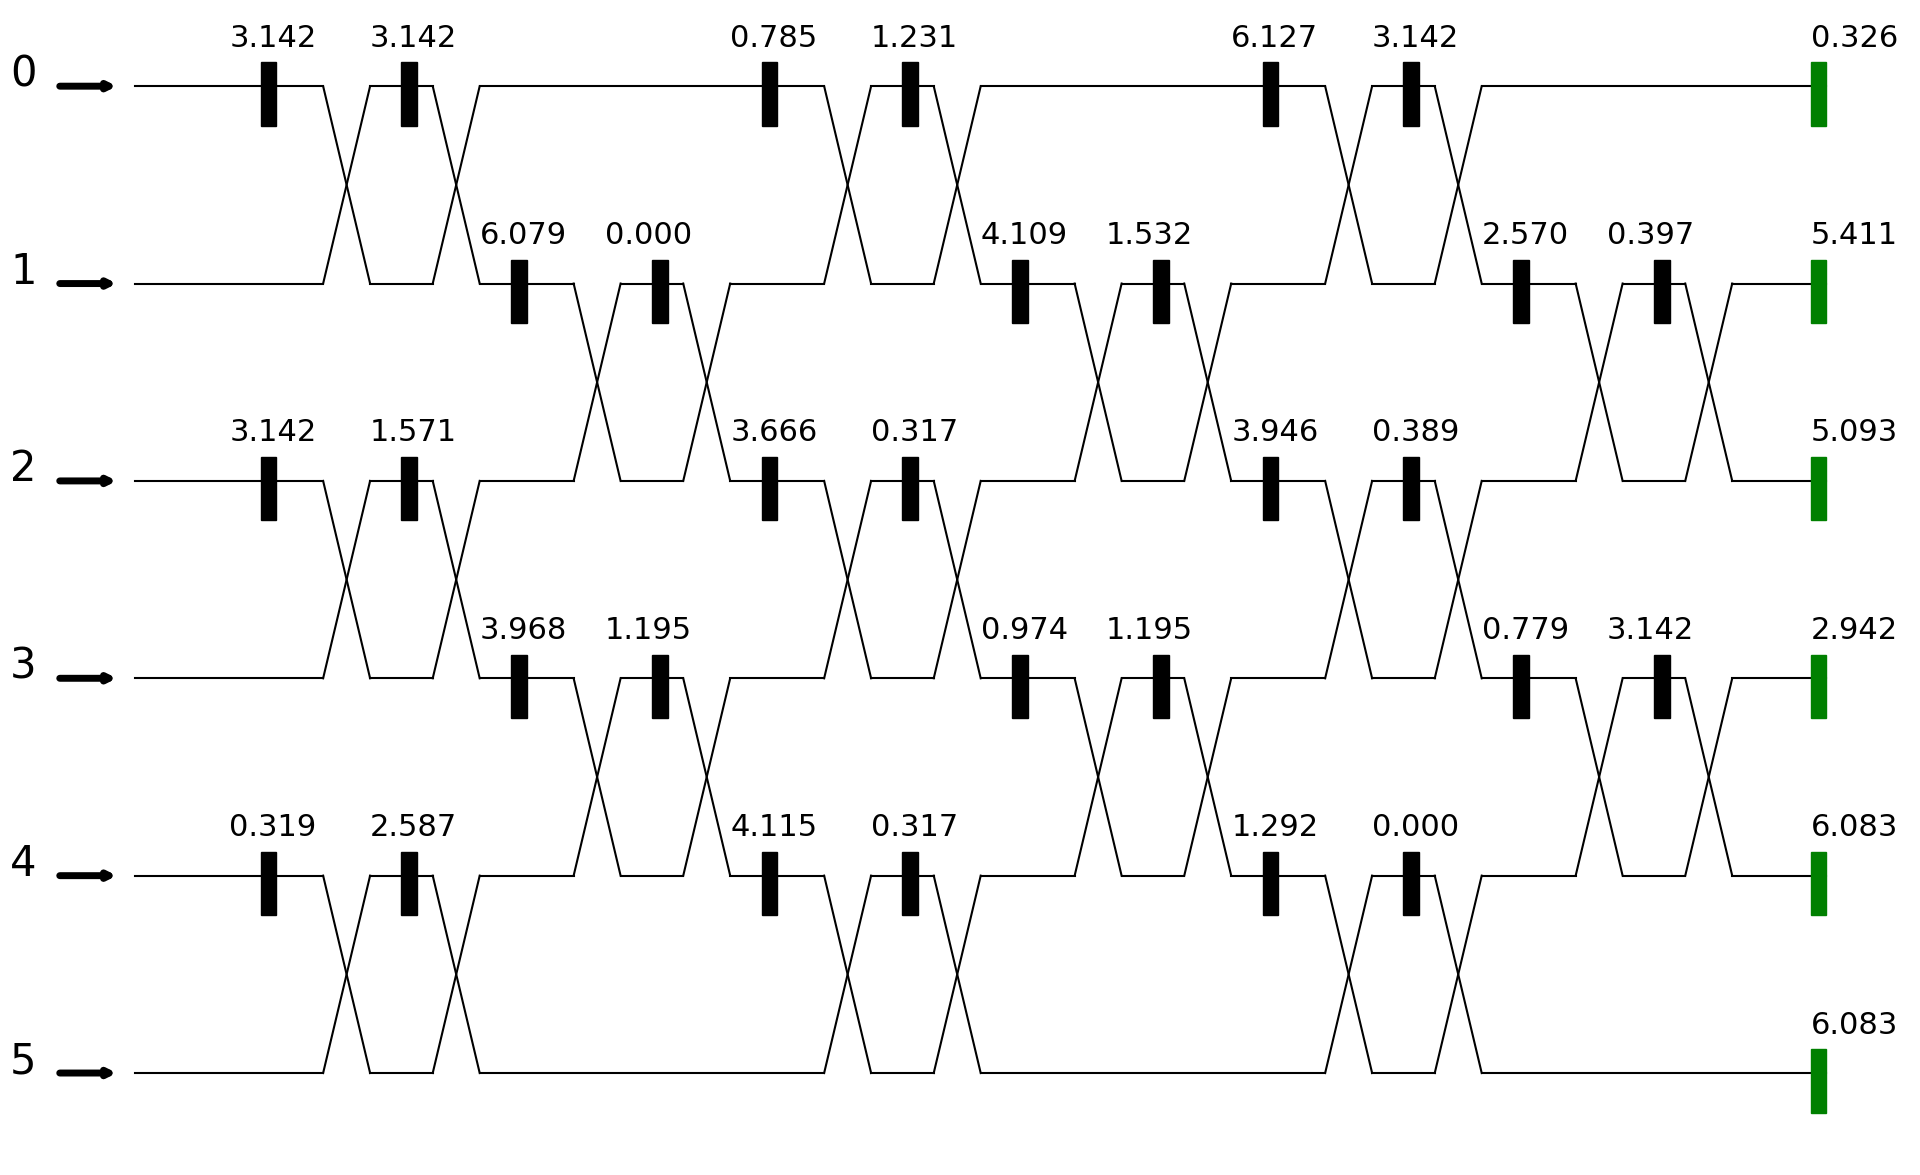

In [42]:
## 构建CNOT线路例子
u6x6 = np.array([[1, 0, 1, -1, 0, 0],
                 [0, 1, 0 ,0,  0, np.sqrt(2)],
                 [1,  0, 0, 1, 1, 0],
                 [-1, 0, 1, 0, 1, 0],
                 [0,  0, 1, 1, -1,0],
                 [0, np.sqrt(2), 0,0,0,-1]])/np.sqrt(3)

ud = dq.UnitaryDecomposer(u6x6)
mzi_info = ud.decomp()
p_mzi = dq.photonic.draw.DrawClements(6, mzi_info[0],cl='black')
p_mzi.plotting_clements()


可以通过deepquantum 手动搭建上图的clements 线路

In [43]:
ini_state = [1,0,1,0,0,0]
dic_mzi = mzi_info[1]
phase_angle = mzi_info[0]['phase_angle']
test_cnot_noise =dq.QumodeCircuit(nmode=6, init_state=ini_state, name="test2", cutoff = 3, basis=True, noise=True) # using state list

for i in range(3):
    for j in [0,2,4]:
        temp_key = (j, j+1)
        para1, para2 = dic_mzi[temp_key][i]
        test_cnot_noise.ps([j],para1)
        test_cnot_noise.bs_theta([j, j+1], np.pi/4)
        test_cnot_noise.ps([j], para2)
        test_cnot_noise.bs_theta([j, j+1],np.pi/4)

    for j in [1,3]:
        temp_key = (j, j+1)
        para1, para2 = dic_mzi[temp_key][i]
        test_cnot_noise.ps([j], para1)
        test_cnot_noise.bs_theta([j, j+1], np.pi/4)
        test_cnot_noise.ps([j], para2)
        test_cnot_noise.bs_theta([j, j+1],np.pi/4)
for k in range(6):
     test_cnot_noise.ps([k], phase_angle[k])
test_cnot_noise.draw()

In [44]:
unitary = test_cnot_noise.get_unitary()
temp_2 = torch.trace(unitary.H @ torch.tensor(u6x6, dtype=torch.cfloat))
fidelity_1 = abs(temp_2/6)**2
print(fidelity_1)

tensor(0.6986)


## Clements 架构光量子线路

使用Clements 模块构建相同的CNOT光量子线路

In [45]:
# 使用clements架构实现cnot门
u6x6 = np.array([[1, 0, 1, -1, 0, 0],
                 [0, 1, 0 ,0,  0, np.sqrt(2)],
                 [1,  0, 0, 1, 1, 0],
                 [-1, 0, 1, 0, 1, 0],
                 [0,  0, 1, 1, -1,0],
                 [0, np.sqrt(2), 0,0,0,-1]])/np.sqrt(3)
# 将酉矩阵分解成clements对应的参数
UD = dq.photonic.decompose.UnitaryDecomposer(u6x6)
mzi_info = UD.decomp()
# 构造clements线路实现cnot门 
clements = dq.photonic.ansatz.Clements(nmode=6, init_state=[1,0,1,0,0,0], cutoff=3)
data = clements.dict2data(mzi_info[2]) # encoding the 6x6 data
re = clements(data = data)
#线路可视化
clements.draw()

# 基于高斯后端构建光量子线路

##  构建连续变量光量子线路

基于高斯后端的光量子线路演化的量子态是高斯态， 高斯态的概念来源于连续变量光量子计算， 它对应的wigner函数为多元高斯分布，比如相干态。
这里用正交分量X，P的协方差矩阵和平均值来刻画连续变量中的量子态，比如真空态对应的协方差矩阵为单位阵，对应的平均值都为0，
通过测量得到的物理量是两个正交分量X，P的值，它们对应的分布满足边缘分布。


这里构建2模线路，初始量子态为真空高斯态， 经过3种高斯门演化之后得到另一个高斯态。S 表示单模真空压缩门， D表示位移门， BS是可调分束器。 

In [46]:
circ = dq.photonic.QumodeCircuit(nmode=2, init_state='vac', cutoff=3, backend='gaussian')
circ.s(wires=[0], inputs=[1,0])
circ.s(wires=[1], inputs=[1,0])
circ.d(wires=[0], inputs=[1,0])
circ.d(wires=[1], inputs=[1,0])
circ.bs(wires=[0,1], inputs=[np.pi/4,np.pi/4])
#线路可视化 
circ.draw()

In [47]:
state = circ() # 线路演化后得到的高斯态用协方差矩阵和平均值刻画
print(state)

[tensor([[[ 1.9488,  0.0000,  1.8134, -2.5646],
         [ 0.0000,  1.9488, -2.5646, -1.8134],
         [ 1.8134, -2.5646,  5.5756,  0.0000],
         [-2.5646, -1.8134,  0.0000,  5.5756]]]), tensor([[[0.4142],
         [2.4142],
         [1.0000],
         [1.0000]]])]


In [48]:
measure_re = circ.measure_homodyne(shots = 1024) #对正交分量进行测量， 这里的每个模对应一组正交分量X，P。
measure_re.shape

torch.Size([1024, 4])

In [49]:
photon_mean, photon_var = circ.photon_number_mean_var()# 计算每个模的平均光子数和光子数方差
photon_mean, photon_var

(tensor([1.6740, 3.0882]), tensor([6.7859, 6.9773]))

## 高斯玻色采样

基于压缩门和线性光学器件可以构建高斯玻色采样线路

In [50]:
# 采用6个节点的图演示简单的高斯玻色采样
a = np.array([[0., 1., 1., 0., 0., 0.],
       [1., 0., 0., 1., 0., 1.],
       [1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 1., 1.],
       [0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 1., 0., 0.]])
gbs = dq.photonic.ansatz.GBS_Graph(adj_mat=torch.tensor(a), cutoff=2)
state = gbs()
sample = gbs.measure(shots=5000)
gbs.draw()

chain 5: 100%|█████████████████████████████| 999/999 [00:00<00:00, 19404.32it/s]


In [51]:
sample 

{|001010>: 1,
 |010001>: 301,
 |000110>: 317,
 |101000>: 385,
 |010100>: 346,
 |000000>: 2336,
 |000101>: 431,
 |110101>: 60,
 |110000>: 413,
 |110110>: 61,
 |101101>: 42,
 |010111>: 65,
 |111001>: 73,
 |101110>: 83,
 |111100>: 76,
 |110011>: 2,
 |111111>: 8}

# 随机电路测试 (与perceval 比较)

In [52]:
import perceval as pcvl
import perceval.components as comp
from perceval.components import BS
import time

In [53]:
## for state list
for test_id in range(100): # run 100 random circuit
    nmode = np.random.randint(2,7)
    ndevice = np.random.randint(10,100)
    ini_state_pre = np.random.randn(nmode)
    ini_state_pre = ini_state_pre-ini_state_pre.min()
    ini_state_pre = np.round(ini_state_pre/ini_state_pre.sum()*nmode)
    ini_state_pre[ini_state_pre<0] = 0
    if ini_state_pre.sum()!=nmode:
        ini_state_pre[ini_state_pre.argmax()] += nmode - ini_state_pre.sum()
    ini_state = [int(i) for i in ini_state_pre]
    ini_state_ts = [(1, ini_state)]
    assert np.sum(ini_state_pre)==nmode

    test_gate = (pcvl.Circuit (nmode, name =" test1 "))

    dq_gate = dq.QumodeCircuit(nmode=nmode, init_state=ini_state, name="test", cutoff = sum(ini_state)+1, basis = True)

    encode = True

    for i in range(ndevice): ## take the random circuit
        j = np.random.uniform(-1,1)
        if j>0:
            temp_1 = int(np.random.choice(np.arange(nmode)))
            angle_1 = np.random.uniform(0,2*np.pi)
            test_gate.add((temp_1),comp.PS(angle_1))
            dq_gate.ps([temp_1],angle_1,encode=encode)
        else:
            k = int(np.random.choice(np.arange(nmode-1)))
            angle_2 = np.random.uniform(0,2*np.pi)
            test_gate.add((k,k+1), BS.Rx(angle_2))
            dq_gate.bs_theta([k, k+1],angle_2/2,encode=encode)


    t1 = time.perf_counter()
    backend = pcvl.BackendFactory().get_backend("Naive")
    backend.set_circuit(test_gate)
    input_state=pcvl.BasicState(ini_state)
    backend.set_input_state(input_state)
    re1 = backend.evolve()
    t2 = time.perf_counter()
    T1 = t2-t1

    t3 = time.perf_counter()
    re2 = dq_gate()
    t4 = time.perf_counter()
    T2 = t4-t3

    ## calculating the difference for two simu approach
    max_error = -1.0
    for key in re1.keys():
        key2 = list(key)
        key3 = dq.photonic.FockState(key2)
        tmp_error =  abs(re2[(key3)]-re1[(key)])
#         tmp_error =  abs(re2[tuple(key2)]-re1[(key)])
        if tmp_error > max_error:
            max_error = tmp_error
    if max_error>1e-3:
        raise Exception("check this case")
    print(f"test_id: {test_id} | max_difference: {'%.4e' %max_error} | T1: {'%.2f' %T1}s | T2: {'%.2f' %T2}s | nm: {nmode} | nd: {ndevice}")

test_id: 0 | max_difference: 2.2838e-06 | T1: 0.02s | T2: 0.15s | nm: 6 | nd: 79
test_id: 1 | max_difference: 7.8976e-07 | T1: 0.01s | T2: 0.03s | nm: 5 | nd: 89
test_id: 2 | max_difference: 8.9407e-08 | T1: 0.00s | T2: 0.00s | nm: 2 | nd: 37
test_id: 3 | max_difference: 8.8279e-07 | T1: 0.01s | T2: 0.03s | nm: 5 | nd: 73
test_id: 4 | max_difference: 4.0395e-06 | T1: 0.03s | T2: 0.20s | nm: 6 | nd: 84
test_id: 5 | max_difference: 1.2288e-07 | T1: 0.00s | T2: 0.00s | nm: 2 | nd: 10
test_id: 6 | max_difference: 1.7270e-06 | T1: 0.03s | T2: 0.11s | nm: 6 | nd: 56
test_id: 7 | max_difference: 3.6652e-07 | T1: 0.00s | T2: 0.01s | nm: 4 | nd: 13
test_id: 8 | max_difference: 1.9332e-06 | T1: 0.02s | T2: 0.09s | nm: 6 | nd: 15
test_id: 9 | max_difference: 1.3448e-06 | T1: 0.01s | T2: 0.02s | nm: 5 | nd: 53
test_id: 10 | max_difference: 7.8398e-07 | T1: 0.00s | T2: 0.01s | nm: 3 | nd: 75
test_id: 11 | max_difference: 6.6390e-07 | T1: 0.00s | T2: 0.04s | nm: 5 | nd: 16
test_id: 12 | max_differen